# Why does a deep gyre exist in North Atlantic region in all positive heat perturbation experiments?

In this notebook, we analyse similarities between the amount of convection (using KPP mixing layer) and strength of the deep gyre in the North Atlantic region. We believe that in our positive heat perturbation experiments, increased convection in the NA occurs, leading to the curl of wind stress propagating to deeper depths, thereby resulting in the formation and sustenance of a deep ocean gyre.

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

import xgcm

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37593,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:41741,Total threads: 4
Dashboard: /proxy/41843/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36767,


In [4]:
db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_control.db'
session_cont = cc.database.create_session(db)


db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_flux_forced_vary_heat_uniform_5W.db'
session_h5W = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_flux_forced_vary_heat_uniform.db'
session_heat = cc.database.create_session(db)

session = [session_cont, session_h5W, session_heat, session_heat]
expt = ['025deg_jra55_ryf_control', '025deg_jra55_ryf_fluxH_pos5W', '025deg_jra55_ryf_fluxH_pos10W', '025deg_jra55_ryf_fluxH_pos20W']
name = ['Control', 'Pos5W', 'Pos10W', 'Pos20W']

In [5]:
start_time = '2203-01-01'
end_time = '2301-12-31'

ncoarse = 12

x_min = [-100, -250]
x_max = [ 10 , -100]
y_min = [ 20 ,  20 ]
y_max = [ 75 ,  75 ]
basin = ['NA', 'NP']

k = 0

In [13]:
T = cc.querying.getvar(expt = expt[0], variable = 'temp', session = session[0], frequency = '1 monthly', n = 1, start_time = '2203-01-01', end_time = '2203-12-31')
T = T.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k])).mean('time').isel(st_ocean = 0)
T_crop = T.sel(xt_ocean = slice(-80, -40)).sel(yt_ocean = slice(30, 45))

area_t = cc.querying.getvar(expt = expt[0], variable = 'area_t', session = session[0], frequency = 'static', n = 1)
area_t = area_t.sel(xt_ocean = slice(-80, -40)).sel(yt_ocean = slice(30, 45))

area_u = cc.querying.getvar(expt = expt[0], variable = 'area_u', session = session[0], frequency = 'static', n = 1)
area_u = area_u.sel(xu_ocean = slice(-80, -40)).sel(yu_ocean = slice(30, 45))

area_t_basin = area_t.where(~np.isnan(T))
area_t = area_t.rename('area_t')
area_u = area_u.rename('area_u')

## Region we are looking at

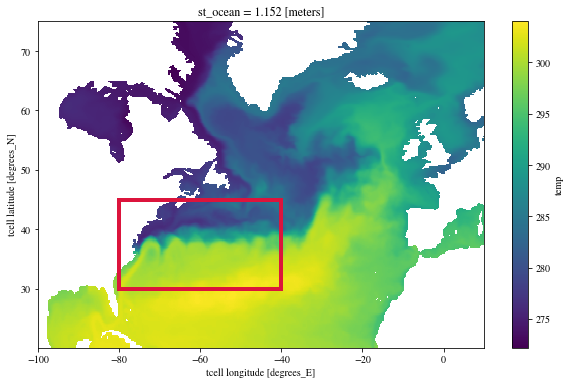

In [16]:
import matplotlib.patches as patches

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))

T.plot(ax = ax)
rect = patches.Rectangle((-80, 30), 40, 15, linewidth = 4, edgecolor = 'crimson', facecolor = 'none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

## Plots

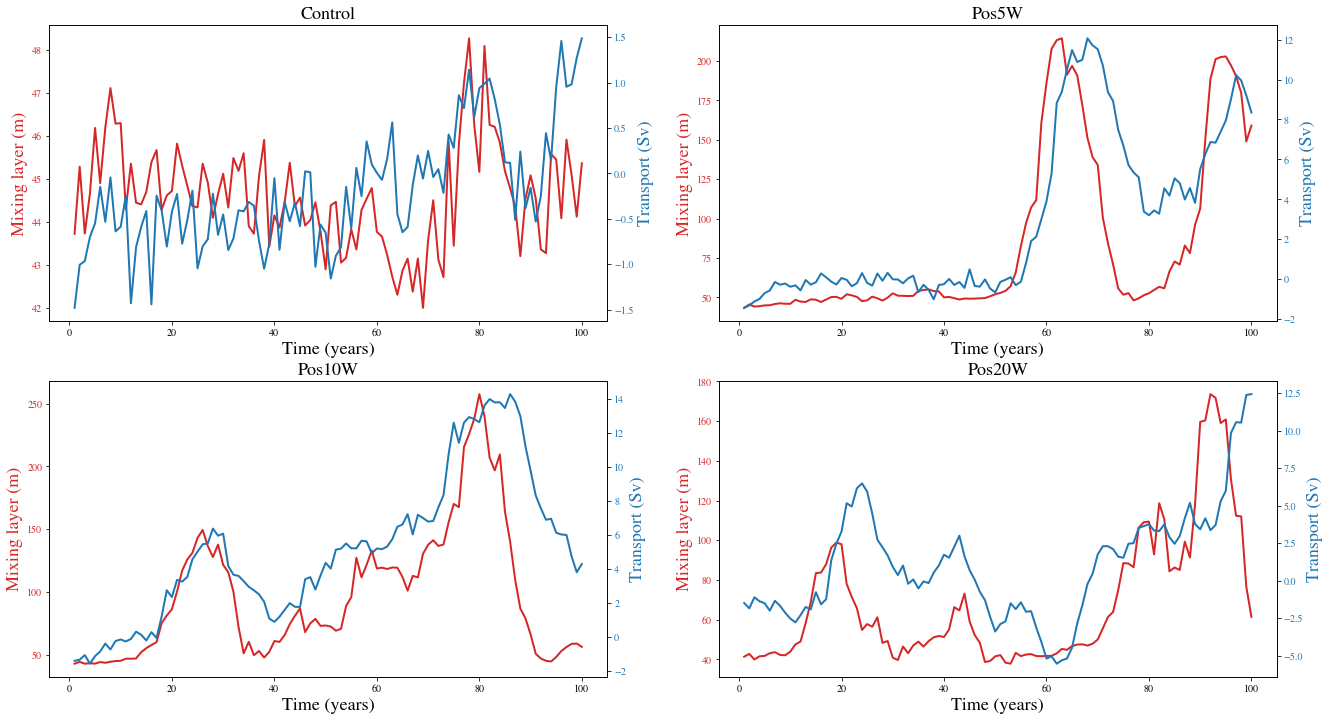

In [17]:
rho0 = 1036
fig, ax1 = plt.subplots(nrows = 2, ncols = 2, figsize = (22, 12))
time = np.linspace(1, 100, 100)
ncoarse = 12

for i, j in enumerate(session):
    
    ## Mixing layer depth for the deep gyre region
    hblt = cc.querying.getvar(expt[i], 'hblt', session = session[i], start_time = start_time, end_time = end_time, use_cftime = True, frequency = '1 monthly')
    hblt = hblt.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
    hblt = hblt.sel(xt_ocean = slice(-80, -40)).sel(yt_ocean = slice(30, 45))
    
    ## Streamfunction for the deep gyre region
    ty_trans = cc.querying.getvar(expt[i], 'ty_trans', session = session[i], start_time = start_time, end_time = end_time, use_cftime = True, frequency = '1 monthly')
    ty_basin = ty_trans.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
    psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
    psi_basin = psi_basin.where(~np.isnan(ty_trans.isel(time = 0)))
    psi_basin = psi_basin.sel(st_ocean = slice(2000, 5000)).sum('st_ocean').sel(xt_ocean = slice(-80, -40)).sel(yu_ocean = slice(30, 45))
    
    ## Taking area-weighted average, and coarsening over time axis
    hblt_avg = (hblt*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
    hblt_avg = hblt_avg.coarsen({"time": ncoarse}, boundary = "trim").mean()
    
    ## Switching streamfunction plot from xt-yu to xt-yt grid
    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((area_t, area_u, psi_basin))
    data.coords['xu_ocean'].attrs.update(axis='X')
    data.coords['xt_ocean'].attrs.update(axis='X', c_grid_axis_shift = 0.5)
    data.coords['yu_ocean'].attrs.update(axis='Y')
    data.coords['yt_ocean'].attrs.update(axis='Y', c_grid_axis_shift = 0.5)

    temp1 = xgcm.Grid(data, periodic = ['X'])
    psi_basin = temp1.interp(psi_basin, 'Y', boundary = "extend")
    
    ## Taking area-weighted average, and coarsening over time axis
    psi_avg = (psi_basin*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
    psi_avg = psi_avg.coarsen({"time": ncoarse}, boundary = "trim").mean()
    
    ## Plotting mixing layer depth and streamfunction to analyse any correlations
    color = 'tab:red'
    ax1[int(i/2)][int(i%2)].set_xlabel('Time (years)', fontsize=18)
    ax1[int(i/2)][int(i%2)].set_ylabel('Mixing layer (m)', color=color, fontsize=18)
    ax1[int(i/2)][int(i%2)].plot(time, hblt_avg, color=color)
    ax1[int(i/2)][int(i%2)].tick_params(axis='y', labelcolor=color)

    ax2 = ax1[int(i/2)][int(i%2)].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Transport (Sv)', color=color, fontsize = 18)  # we already handled the x-label with ax1
    ax2.plot(time, psi_avg, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    ax1[int(i/2)][int(i%2)].set_title(name[i], fontsize = 18)